In [1]:
from google.colab import files

# Subimos el CSV exportado desde R
uploaded = files.upload()


Saving Madrid_limpio.csv to Madrid_limpio.csv


In [2]:
import pandas as pd

# Cargamos el CSV
df = pd.read_csv("Madrid_limpio.csv")

# Vistazo general
df.shape
df.head()
df.columns


Index(['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'FLOORCLEAN', 'HASLIFT', 'HASTERRACE', 'HASAIRCONDITIONING',
       'HASPARKINGSPACE', 'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASWARDROBE', 'HASDOORMAN', 'HASGARDEN', 'HASSWIMMINGPOOL',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'CADCONSTRUCTIONYEAR', 'BUILTTYPEID_1',
       'BUILTTYPEID_2', 'BUILTTYPEID_3', 'LATITUDE', 'LONGITUDE',
       'PRICE_PER_M2', 'ANTIGUEDAD', 'FLOOR_CAT', 'TIPO_CONSTRUCCION'],
      dtype='object')

In [3]:
import geopandas as gpd
from shapely.geometry import Point

# Convertimos lat/lon en geometría
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE), crs="EPSG:4326")

# Visualizamos los primeros puntos
gdf.head()


,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,FLOORCLEAN,HASLIFT,HASTERRACE,HASAIRCONDITIONING,HASPARKINGSPACE,...,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,LATITUDE,LONGITUDE,PRICE_PER_M2,ANTIGUEDAD,FLOOR_CAT,TIPO_CONSTRUCCION,geometry
0,126000.0,2680.851064,47,1,1,1,1,0,1,0,...,0,1,0,40.362485,-3.766933,2680.851064,13,Bajo,Bloque,POINT (-3.76693 40.36248)
1,235000.0,4351.851852,54,1,1,1,0,0,0,0,...,0,0,1,40.422430,-3.710725,4351.851852,118,Bajo,Multivivienda,POINT (-3.71072 40.42243)
2,373000.0,4973.333333,75,2,1,3,0,0,1,0,...,0,0,1,40.422190,-3.711571,4973.333333,103,Medio,Multivivienda,POINT (-3.71157 40.42219)
3,284000.0,5916.666667,48,1,1,1,1,0,1,0,...,0,0,1,40.422251,-3.710440,5916.666667,71,Bajo,Multivivienda,POINT (-3.71044 40.42225)
4,228000.0,4560.000000,50,0,1,0,0,0,0,0,...,0,0,1,40.408741,-3.714340,4560.000000,88,Entresuelo,Multivivienda,POINT (-3.71434 40.40874)


In [4]:
# 🧠 1. Preparamos los datos para modelar
import numpy as np

df_model = df.copy()
df_model["LOG_PRICE"] = np.log10(df_model["PRICE"])  # Transformación de la variable objetivo

# 🧱 2. Convertimos variables categóricas a dummies
df_model = pd.get_dummies(df_model, columns=["FLOOR_CAT", "TIPO_CONSTRUCCION"], drop_first=False)

# ✨ 3. Selección de variables predictoras
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASLIFT', 'HASTERRACE', 'HASAIRCONDITIONING',
    'HASGARDEN', 'HASSWIMMINGPOOL', 'DISTANCE_TO_CITY_CENTER', 'ANTIGUEDAD'
]

# Añadimos dummies
dummies = [col for col in df_model.columns if col.startswith("FLOOR_CAT_") or col.startswith("TIPO_CONSTRUCCION_")]
features += dummies

X = df_model[features]
y = df_model["LOG_PRICE"]

# 🔍 4. Eliminamos cualquier fila con valores nulos
model_data = pd.concat([X, y], axis=1)
model_data_clean = model_data.dropna()

X_clean = model_data_clean.drop(columns=["LOG_PRICE"])
y_clean = model_data_clean["LOG_PRICE"]

# 🔀 5. División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# 🤖 6. Entrenamiento del modelo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

# 📈 7. Evaluación
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(0.15105600992228493), 0.7618860216133879)

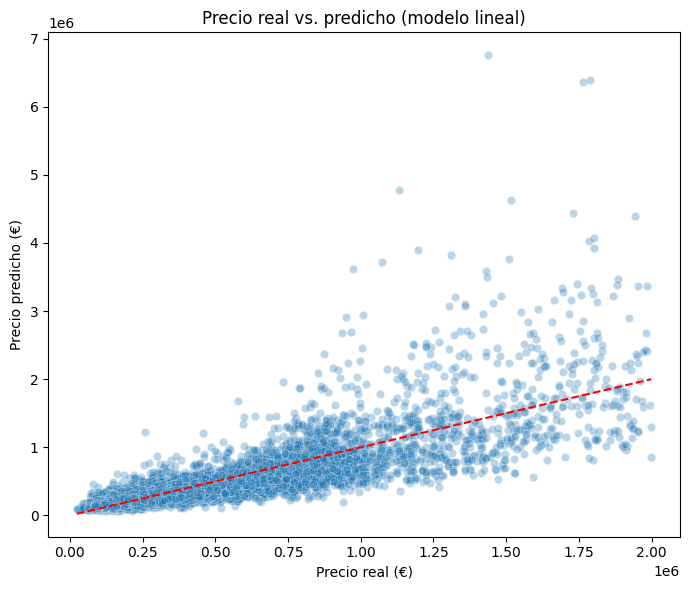

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recuperamos predicciones y las convertimos de log10 a escala original
y_pred_real = 10 ** y_pred
y_test_real = 10 ** y_test

# Gráfico de dispersión: precio real vs. predicho
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.3)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')  # línea de identidad
plt.xlabel("Precio real (€)")
plt.ylabel("Precio predicho (€)")
plt.title("Precio real vs. predicho (modelo lineal)")
plt.tight_layout()
plt.show()


In [7]:
polygons = gpd.read_file("Madrid_Polygons.shp")
# Mostramos las primeras columnas
polygons.head()
# Unión espacial usando LOCATIONN
gdf_zonas = gpd.sjoin(gdf, polygons[["LOCATIONN", "geometry"]], how="left", predicate="within")

# Guardamos el resultado
gdf_zonas.drop(columns="geometry").to_csv("/content/Madrid_limpio_con_zona.csv", index=False)

gdf_zonas[['LOCATIONN']].value_counts().head(10)


<ipython-input-7-52ab5fad5f5b>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84 ...

  gdf_zonas = gpd.sjoin(gdf, polygons[["LOCATIONN", "geometry"]], how="left", predicate="within")


,count
LOCATIONN,
Lavapiés-Embajadores,3591
Malasaña-Universidad,2463
Goya,1959
Palacio,1726
Guindalera,1687
Pueblo Nuevo,1671
San Diego,1519
Chueca-Justicia,1458
San Andrés,1378


In [8]:
# Cargamos el CSV con LOCATIONN
df = pd.read_csv("/content/Madrid_limpio_con_zona.csv")

# Transformamos y preparamos los datos
df_model = df.copy()
df_model["LOG_PRICE"] = np.log10(df_model["PRICE"])
df_model = pd.get_dummies(df_model, columns=["FLOOR_CAT", "TIPO_CONSTRUCCION", "LOCATIONN"], drop_first=True)

# Variables predictoras
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASLIFT', 'HASTERRACE', 'HASAIRCONDITIONING',
    'HASGARDEN', 'HASSWIMMINGPOOL', 'DISTANCE_TO_CITY_CENTER', 'ANTIGUEDAD'
]
features += [col for col in df_model.columns if col.startswith("FLOOR_CAT_")]
features += [col for col in df_model.columns if col.startswith("TIPO_CONSTRUCCION_")]
features += [col for col in df_model.columns if col.startswith("LOCATIONN_")]

# Limpieza y separación
X = df_model[features]
y = df_model["LOG_PRICE"]
model_data = pd.concat([X, y], axis=1).dropna()
X_clean = model_data.drop(columns=["LOG_PRICE"])
y_clean = model_data["LOG_PRICE"]

# División y modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Coeficientes ordenados por impacto
coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model.coef_
})
coef_df["ImpactoAbs"] = coef_df["Coeficiente"].abs()
coef_df_sorted = coef_df.sort_values(by="ImpactoAbs", ascending=False)

rmse, r2, coef_df_sorted.head(20)


(np.float64(0.10035576501641871),
 0.8946256615626111,
                                        Variable  Coeficiente  ImpactoAbs
 119                         LOCATIONN_Recoletos     0.481013    0.481013
 46                         LOCATIONN_Castellana     0.439960    0.439960
 64                            LOCATIONN_El Viso     0.411826    0.411826
 21                            LOCATIONN_Almagro     0.392567    0.392567
 84                              LOCATIONN_Lista     0.389187    0.389187
 72                               LOCATIONN_Goya     0.384775    0.384775
 34            LOCATIONN_Bernabéu-Hispanoamérica     0.375981    0.375981
 96                       LOCATIONN_Nueva España     0.370090    0.370090
 49                    LOCATIONN_Chueca-Justicia     0.369230    0.369230
 79                          LOCATIONN_Jerónimos     0.365350    0.365350
 77                              LOCATIONN_Ibiza     0.364443    0.364443
 93                       LOCATIONN_Montecarmelo     0.35

In [ ]:
# Visualización: Precio real vs Predicho (con zona incluida)

import matplotlib.pyplot as plt
import seaborn as sns

# Convertimos de log10 a escala real
y_pred_real = 10 ** y_pred
y_test_real = 10 ** y_test

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.3)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--')
plt.xlabel("Precio real (€)")
plt.ylabel("Precio predicho (€)")
plt.title("Precio real vs. predicho (modelo lineal con zona)")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definimos el espacio de búsqueda
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['auto', 'sqrt', 0.8]
}

# Configuración del RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,             # Número de combinaciones a probar
    cv=3,                  # Validación cruzada de 3 folds
    scoring='r2',          # Optimizamos R²
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenamos
random_search.fit(X_train, y_train)

# Evaluamos el mejor modelo
best_rf = random_search.best_estimator_
y_pred_test = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("🌟 Mejor combinación de hiperparámetros:", random_search.best_params_)
print(f"RMSE (test): {rmse:.2f}")
print(f"R² (test): {r2:.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

🌟 Mejor combinación de hiperparámetros: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': None}
RMSE (test): 0.08
R² (test): 0.940


In [15]:
# Predicción en entrenamiento
y_pred_train = best_rf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Predicción en test (ya la hiciste, pero lo dejamos por claridad)
y_pred_test = best_rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Mostrar resultados comparados
print("🎯 Rendimiento final del modelo óptimo (Random Forest)")
print(f"Entrenamiento - RMSE: {rmse_train:.2f}, R²: {r2_train:.3f}")
print(f"Test          - RMSE: {rmse_test:.2f}, R²: {r2_test:.3f}")


🎯 Rendimiento final del modelo óptimo (Random Forest)
Entrenamiento - RMSE: 0.04, R²: 0.986
Test          - RMSE: 0.08, R²: 0.940


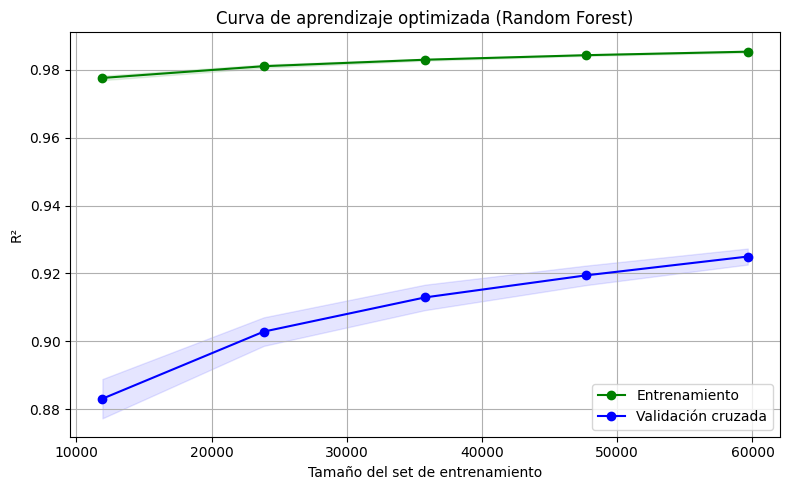

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Clonamos el modelo óptimo pero reducimos temporalmente los árboles para acelerar
from sklearn.base import clone
fast_rf = clone(best_rf)
fast_rf.set_params(n_estimators=100)

# Curva de aprendizaje optimizada
train_sizes, train_scores, test_scores = learning_curve(
    estimator=fast_rf,
    X=X_clean,
    y=y_clean,
    train_sizes=np.linspace(0.2, 1.0, 5),  # Solo 5 tamaños
    cv=3,                                  # 3 folds
    scoring='r2',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Medias y desviaciones estándar
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='green', label='Entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='blue', label='Validación cruzada')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='blue')
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.title("Curva de aprendizaje optimizada (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Gráfico de dispersión: Precio real vs. Precio predicho para Random Forest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=10 ** y_test, y=10 ** y_pred_rf, alpha=0.3)
plt.plot([10 ** y_test.min(), 10 ** y_test.max()],
         [10 ** y_test.min(), 10 ** y_test.max()],
         'r--')
plt.xlabel("Precio real (€)")
plt.ylabel("Precio predicho (€)")
plt.title("Precio real vs. predicho (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
# Visualizamos la importancia de las variables en Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Creamos un DataFrame ordenado
importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# Mostramos el top 20
top_20 = importance_df.head(20)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20, y="Variable", x="Importancia", palette="viridis")
plt.title("Importancia de variables (Random Forest)")
plt.tight_layout()
plt.show()

top_20


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Creamos una función para entrenar y evaluar modelos
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre="Modelo"):
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    return {"Modelo": nombre, "RMSE": rmse, "R²": r2}

# Escalamos los datos para SVM y KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a evaluar
modelos = [
    (LinearRegression(), "Regresión Lineal"),
    (Ridge(alpha=1.0), "Ridge"),
    (GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42), "Gradient Boosting"),
    (SVR(), "SVM (SVR)"),
    (KNeighborsRegressor(n_neighbors=5), "KNN (k=5)"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest")
]

# Evaluamos los modelos
resultados = []
for modelo, nombre in modelos:
    if nombre in ["SVM (SVR)", "KNN (k=5)"]:
        res = evaluar_modelo(modelo, X_train_scaled, X_test_scaled, y_train, y_test, nombre)
    else:
        res = evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre)
    resultados.append(res)

# Mostramos los resultados ordenados por R²
import pandas as pd
df_resultados = pd.DataFrame(resultados).sort_values(by="R²", ascending=False)
# Mostrar el DataFrame con los resultados sin usar ace_tools
df_resultados.reset_index(drop=True, inplace=True)
df_resultados.style.format({"RMSE": "{:,.0f}", "R²": "{:.3f}"})



In [ ]:
# 📦 Carga de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 🚀 Carga de datos
df = pd.read_csv("/content/Madrid_limpio_con_zona.csv")

# 🧼 Selección y limpieza de variables
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'FLOORCLEAN', 'HASLIFT',
    'HASTERRACE', 'HASAIRCONDITIONING', 'HASPARKINGSPACE', 'HASWARDROBE',
    'HASDOORMAN', 'HASGARDEN', 'HASSWIMMINGPOOL', 'DISTANCE_TO_CITY_CENTER',
    'ANTIGUEDAD'
]
df_model = df[features + ["PRICE"]].dropna()
X = df_model[features]
y = np.log10(df_model["PRICE"])

# ✂️ División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📏 Escalado para SVM y KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🤖 Modelos a evaluar
modelos = [
    (LinearRegression(), "Regresión Lineal"),
    (Ridge(alpha=1.0), "Ridge"),
    (GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42), "Gradient Boosting"),
    (SVR(), "SVM (SVR)"),
    (KNeighborsRegressor(n_neighbors=5), "KNN (k=5)"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest")
]

# 📊 Evaluación y almacenamiento
resultados = []
modelos_entrenados = {}

for modelo, nombre in modelos:
    if nombre in ["SVM (SVR)", "KNN (k=5)"]:
        modelo.fit(X_train_scaled, y_train)
        pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    resultados.append({"Modelo": nombre, "RMSE": rmse, "R²": r2})
    modelos_entrenados[nombre] = modelo

# 📋 Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by="R²", ascending=False).reset_index(drop=True)
df_resultados


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Definimos un grid reducido de búsqueda
param_distributions = {
    'C': [1, 10],
    'epsilon': [0.1, 1],
    'kernel': ['rbf']  # El kernel 'linear' suele rendir peor para datos no lineales
}

# RandomizedSearchCV: evalúa 4 combinaciones al azar con validación cruzada
random_svr = RandomizedSearchCV(
    SVR(),
    param_distributions=param_distributions,
    n_iter=4,           # Solo 4 combinaciones
    scoring='r2',
    cv=2,               # Validación cruzada de 2 folds
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenamos (usa los datos escalados)
random_svr.fit(X_train_scaled, y_train)

# Mejor modelo
best_svr = random_svr.best_estimator_
print("Mejor combinación de hiperparámetros:", random_svr.best_params_)

# Predicciones y métricas
y_pred_svr = best_svr.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred_svr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("R²:", round(r2, 3))
print("RMSE:", round(rmse, 3))


In [ ]:
import statsmodels.formula.api as smf

# Creamos un dataframe solo con columnas numéricas ya transformadas
df_model = df[[
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'ANTIGUEDAD',
    'HASLIFT', 'HASAIRCONDITIONING', 'HASPARKINGSPACE', 'HASGARDEN',
    'HASSWIMMINGPOOL', 'DISTANCE_TO_CITY_CENTER', 'PRICE'
]].dropna()

# Transformación del precio (log)
df_model["log_price"] = np.log10(df_model["PRICE"])

# Ajustamos regresión cuantilílica para varios percentiles
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    mod = smf.quantreg("log_price ~ CONSTRUCTEDAREA + ROOMNUMBER + BATHNUMBER + ANTIGUEDAD + HASLIFT + HASAIRCONDITIONING + HASPARKINGSPACE + HASGARDEN + HASSWIMMINGPOOL + DISTANCE_TO_CITY_CENTER", df_model)
    res = mod.fit(q=q)
    models[q] = res
    print(f"\n----- Cuantil {q} -----")
    print(res.summary())


In [ ]:
import matplotlib.pyplot as plt

coef_dict = {var: [] for var in models[0.1].params.index}

for q in quantiles:
    for var in coef_dict:
        coef_dict[var].append(models[q].params[var])

# Gráfico de coeficientes
for var, coef_list in coef_dict.items():
    if var != "Intercept":
        plt.plot(quantiles, coef_list, marker='o', label=var)

plt.xlabel("Cuantil")
plt.ylabel("Coeficiente")
plt.title("Comparación de coeficientes por cuantil")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


Los resultados revelan patrones muy interesantes:

🟪 HASLIFT (ascensor) muestra un coeficiente positivo y creciente hacia los cuantiles superiores, lo que indica que su efecto es más relevante en viviendas caras. Esto sugiere que la presencia de ascensor puede tener un mayor impacto en el valor de propiedades de gama alta, posiblemente por estar ubicadas en edificios altos o premium.

🟨 HASAIRCONDITIONING (aire acondicionado) también presenta una influencia positiva estable, aunque ligeramente decreciente, lo que indica que es valorado en todos los segmentos, pero especialmente en los intermedios.

🟩 BATHNUMBER mantiene un impacto positivo moderado y estable en toda la distribución, lo que valida su importancia como predictor del precio.

🟥 ANTIGUEDAD (años desde construcción) tiene un efecto ligeramente negativo y relativamente constante en todos los cuantiles, como era de esperar: a mayor antigüedad, menor valor.

🔵 DISTANCE_TO_CITY_CENTER tiene un coeficiente negativo creciente, lo que sugiere que la localización central es más decisiva en el segmento alto del mercado (cuantil 0.9), donde los compradores valoran mucho la proximidad al centro urbano.

🟧 ROOMNUMBER cambia de signo a lo largo de los cuantiles, lo que sugiere que su efecto no es lineal ni uniforme: en viviendas de bajo coste puede no estar correlacionado con el precio (por ejemplo, en viviendas compartidas o reformadas), mientras que en viviendas caras pierde importancia frente a otras comodidades.

🟫 Variables como HASPARKINGSPACE o HASSWIMMINGPOOL muestran una ligera disminución en el efecto hacia los cuantiles altos, lo que podría deberse a que ya están implícitas en la gama alta y por tanto no añaden valor marginal adicional.

🧠 Interpretación general
Este análisis demuestra que el impacto de ciertos atributos varía a lo largo del espectro de precios. Variables como el ascensor o la distancia al centro tienen mayor peso en viviendas caras, mientras que características como el número de habitaciones no muestran un patrón claro. Este tipo de hallazgos no solo mejora la comprensión del mercado, sino que también puede ayudar a ajustar los modelos predictivos, por ejemplo, mediante técnicas de modelado segmentado o diseño de submodelos por rangos de precio.




nálisis más visual e intuitivo: el mapa de errores de predicción. Este paso es ideal para demostrar la capacidad espacial del modelo y detectar si hay zonas donde sobrevalora o infravalora los inmuebles.

🗺️ Mapa de errores de predicción con Folium (en Google Colab o Jupyter)
Este código asume que ya tienes:

Un modelo entrenado (por ejemplo, Random Forest)

Predicciones en log(PRICE)

Coordenadas (LATITUDE, LONGITUDE)

El dataframe original df



In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# 1. Creamos copia del set de test
df_resultados = X_test.copy()
df_resultados["price_real"] = y_test.values

# 2. Generamos predicciones en euros (no log)
modelo = modelos_entrenados["Random Forest"]  # O cualquier otro
df_resultados["price_pred"] = modelo.predict(X_test)

# 3. Calculamos errores
df_resultados["error_abs"] = df_resultados["price_pred"] - df_resultados["price_real"]
df_resultados["error_pct"] = df_resultados["error_abs"] / df_resultados["price_real"]

# 4. Añadimos coordenadas desde el dataframe original
df_resultados["LATITUDE"] = df.loc[df_resultados.index, "LATITUDE"]
df_resultados["LONGITUDE"] = df.loc[df_resultados.index, "LONGITUDE"]

# 5. Mapa interactivo
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)
cluster = MarkerCluster().add_to(m)

for _, row in df_resultados.iterrows():
    if pd.notnull(row["LATITUDE"]) and pd.notnull(row["LONGITUDE"]):
        color = (
            "green" if row["error_pct"] < -0.25 else
            "red" if row["error_pct"] > 0.25 else
            "blue"
        )
        popup_text = (
            f"<b>Real:</b> {round(row['price_real']):,} €<br>"
            f"<b>Predicho:</b> {round(row['price_pred']):,} €<br>"
            f"<b>Error:</b> {round(row['error_abs']):,} € "
            f"({round(row['error_pct'] * 100, 1)}%)"
        )
        folium.CircleMarker(
            location=[row["LATITUDE"], row["LONGITUDE"]],
            radius=3,
            fill=True,
            color=color,
            fill_opacity=0.5,
            popup=popup_text,
        ).add_to(cluster)

m


In [ ]:
# 1. Añadir la zona (barrio o distrito) a los resultados
df_resultados["LOCATIONN"] = df.loc[df_resultados.index, "LOCATIONN"]

# 2. Agrupar por zona
df_zonas = df_resultados.groupby("LOCATIONN").agg(
    precio_real_medio=("price_real", "mean"),
    precio_predicho_medio=("price_pred", "mean"),
    error_medio=("error_abs", "mean"),
    error_pct_medio=("error_pct", "mean"),
    n_observaciones=("price_real", "count")
).reset_index()

# 3. Ordenar por mayor error porcentual
df_zonas = df_zonas.sort_values(by="error_pct_medio", ascending=False)

# 4. Mostrar tabla
import pandas as pd
import IPython.display as display

display.display(df_zonas.head(10))


In [ ]:
import geopandas as gpd

# Cargar shapefile si no lo tienes en memoria
# Si ya lo tienes, salta esta línea
Madrid_Polygons = gpd.read_file("/content/Madrid_Polygons.shp")  # ajusta la ruta si es necesario
# Asegúrate de que el nombre de zona coincida: LOCATIONN
Madrid_Polygons = Madrid_Polygons.copy()
Madrid_Polygons["LOCATIONN"] = Madrid_Polygons["LOCATIONN"].str.strip()

# Unimos con el resumen por zona
gdf = Madrid_Polygons.merge(df_zonas, on="LOCATIONN", how="left")
import folium
from branca.colormap import linear

# Mapa base
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Colormap para error porcentual
colormap = linear.RdYlGn_11.scale(gdf["error_pct_medio"].min(), gdf["error_pct_medio"].max())
colormap.caption = "Error porcentual medio (predicho - real)"
colormap.add_to(m)

# Pintamos cada zona con color según error
for _, row in gdf.iterrows():
    if pd.notnull(row["error_pct_medio"]):
        color = colormap(row["error_pct_medio"])
        popup = folium.Popup(f"""
            <b>{row['LOCATIONN']}</b><br>
            <b>Precio real medio:</b> {round(row['precio_real_medio']):,} €<br>
            <b>Precio predicho medio:</b> {round(row['precio_predicho_medio']):,} €<br>
            <b>Error:</b> {round(row['error_pct_medio'] * 100, 1)}%<br>
            <b>Observaciones:</b> {row['n_observaciones']}
        """, max_width=300)
        geojson = folium.GeoJson(row["geometry"], style_function=lambda x, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7
        })
        geojson.add_child(popup)
        geojson.add_to(m)

m
